In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [2]:
# XOR Problem Data
# Input: 4 data points with 2 features each
X = torch.tensor([[0.0, 0.0],
                  [0.0, 1.0],
                  [1.0, 0.0],
                  [1.0, 1.0]])

# XOR Output: 0 XOR 0 = 0, 0 XOR 1 = 1, 1 XOR 0 = 1, 1 XOR 1 = 0
y = torch.tensor([[0.0],
                  [1.0],
                  [1.0],
                  [0.0]])

print("Input Data (X):")
print(X)
print("\nTarget Output (y):")
print(y)

Input Data (X):
tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]])

Target Output (y):
tensor([[0.],
        [1.],
        [1.],
        [0.]])


In [3]:
def sigmoid(x):
    """Sigmoid activation function: σ(x) = 1 / (1 + e^(-x))"""
    return 1 / (1 + torch.exp(-x))

def sigmoid_derivative(x):
    """Derivative of sigmoid: σ'(x) = σ(x) * (1 - σ(x))"""
    s = sigmoid(x)
    return s * (1 - s)

def relu(x):
    """ReLU activation function: max(0, x)"""
    return torch.maximum(x, torch.tensor(0.0))

def relu_derivative(x):
    """Derivative of ReLU: 1 if x > 0 else 0"""
    return (x > 0).float()

# Test the functions
test_input = torch.tensor([-2.0, -1.0, 0.0, 1.0, 2.0])
print("Test input:", test_input)
print("Sigmoid output:", sigmoid(test_input))
print("ReLU output:", relu(test_input))

Test input: tensor([-2., -1.,  0.,  1.,  2.])
Sigmoid output: tensor([0.1192, 0.2689, 0.5000, 0.7311, 0.8808])
ReLU output: tensor([0., 0., 0., 1., 2.])


In [4]:
# Network architecture
input_size = 2
hidden_size = 4
output_size = 1

# Initialize weights and biases with small random values
# Xavier initialization for better training

# Weights from input to hidden layer (2x4 matrix)
W1 = torch.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
b1 = torch.zeros(1, hidden_size)

# Weights from hidden to output layer (4x1 matrix)
W2 = torch.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
b2 = torch.zeros(1, output_size)

print("W1 (Input → Hidden) shape:", W1.shape)
print(W1)
print("\nb1 shape:", b1.shape)
print(b1)
print("\nW2 (Hidden → Output) shape:", W2.shape)
print(W2)
print("\nb2 shape:", b2.shape)
print(b2)

W1 (Input → Hidden) shape: torch.Size([2, 4])
tensor([[ 0.3367,  0.1288,  0.2345,  0.2303],
        [-1.1229, -0.1863,  2.2082, -0.6380]])

b1 shape: torch.Size([1, 4])
tensor([[0., 0., 0., 0.]])

W2 (Hidden → Output) shape: torch.Size([4, 1])
tensor([[0.3264],
        [0.1890],
        [0.3782],
        [0.5723]])

b2 shape: torch.Size([1, 1])
tensor([[0.]])


In [5]:
def forward(X, W1, b1, W2, b2):
    """
    Forward propagation through the network.
    Returns all intermediate values for backpropagation.
    """
    # Layer 1: Input → Hidden
    z1 = torch.matmul(X, W1) + b1  # Linear combination
    a1 = sigmoid(z1)                # Activation
    
    # Layer 2: Hidden → Output
    z2 = torch.matmul(a1, W2) + b2  # Linear combination
    a2 = sigmoid(z2)                 # Output activation
    
    return z1, a1, z2, a2

# Test forward pass
z1, a1, z2, y_pred = forward(X, W1, b1, W2, b2)

print("Hidden layer pre-activation (z1):")
print(z1)
print("\nHidden layer activation (a1):")
print(a1)
print("\nOutput layer pre-activation (z2):")
print(z2)
print("\nPredicted output (y_pred):")
print(y_pred)

Hidden layer pre-activation (z1):
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [-1.1229, -0.1863,  2.2082, -0.6380],
        [ 0.3367,  0.1288,  0.2345,  0.2303],
        [-0.7862, -0.0575,  2.4427, -0.4077]])

Hidden layer activation (a1):
tensor([[0.5000, 0.5000, 0.5000, 0.5000],
        [0.2455, 0.4536, 0.9010, 0.3457],
        [0.5834, 0.5322, 0.5583, 0.5573],
        [0.3130, 0.4856, 0.9200, 0.3995]])

Output layer pre-activation (z2):
tensor([[0.7330],
        [0.7045],
        [0.8212],
        [0.7706]])

Predicted output (y_pred):
tensor([[0.6755],
        [0.6692],
        [0.6945],
        [0.6836]])


In [6]:
def mse_loss(y_true, y_pred):
    """Mean Squared Error loss"""
    return torch.mean((y_true - y_pred) ** 2)

# Calculate initial loss
initial_loss = mse_loss(y, y_pred)
print(f"Initial Loss: {initial_loss.item():.4f}")

Initial Loss: 0.2816


In [7]:
def backward(X, y, z1, a1, z2, a2, W1, W2):
    """
    Backpropagation to compute gradients.
    """
    m = X.shape[0]  # Number of samples
    
    # Output layer error
    # dL/da2 = 2*(a2 - y)/m, da2/dz2 = sigmoid_derivative(z2)
    delta2 = (a2 - y) * sigmoid_derivative(z2)
    
    # Gradients for W2 and b2
    dW2 = torch.matmul(a1.T, delta2) / m
    db2 = torch.sum(delta2, dim=0, keepdim=True) / m
    
    # Hidden layer error (backpropagate through W2)
    delta1 = torch.matmul(delta2, W2.T) * sigmoid_derivative(z1)
    
    # Gradients for W1 and b1
    dW1 = torch.matmul(X.T, delta1) / m
    db1 = torch.sum(delta1, dim=0, keepdim=True) / m
    
    return dW1, db1, dW2, db2

# Test backward pass
dW1, db1, dW2, db2 = backward(X, y, z1, a1, z2, y_pred, W1, W2)

print("Gradient dW1 shape:", dW1.shape)
print("Gradient dW2 shape:", dW2.shape)

Gradient dW1 shape: torch.Size([2, 4])
Gradient dW2 shape: torch.Size([4, 1])


In [8]:
# Hyperparameters
learning_rate = 1.0
epochs = 10000

# Re-initialize weights
torch.manual_seed(42)
W1 = torch.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
b1 = torch.zeros(1, hidden_size)
W2 = torch.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
b2 = torch.zeros(1, output_size)

# Store losses for plotting
losses = []

# Training loop
for epoch in range(epochs):
    # Forward pass
    z1, a1, z2, y_pred = forward(X, W1, b1, W2, b2)
    
    # Compute loss
    loss = mse_loss(y, y_pred)
    losses.append(loss.item())
    
    # Backward pass
    dW1, db1, dW2, db2 = backward(X, y, z1, a1, z2, y_pred, W1, W2)
    
    # Update weights (Gradient Descent)
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    # Print progress
    if epoch % 1000 == 0:
        print(f"Epoch {epoch:5d} | Loss: {loss.item():.6f}")

print(f"\nFinal Loss: {losses[-1]:.6f}")

Epoch     0 | Loss: 0.281600
Epoch  1000 | Loss: 0.151973
Epoch  2000 | Loss: 0.013244
Epoch  3000 | Loss: 0.004259
Epoch  4000 | Loss: 0.002368
Epoch  5000 | Loss: 0.001605
Epoch  6000 | Loss: 0.001201
Epoch  7000 | Loss: 0.000955
Epoch  8000 | Loss: 0.000790
Epoch  9000 | Loss: 0.000672

Final Loss: 0.000583


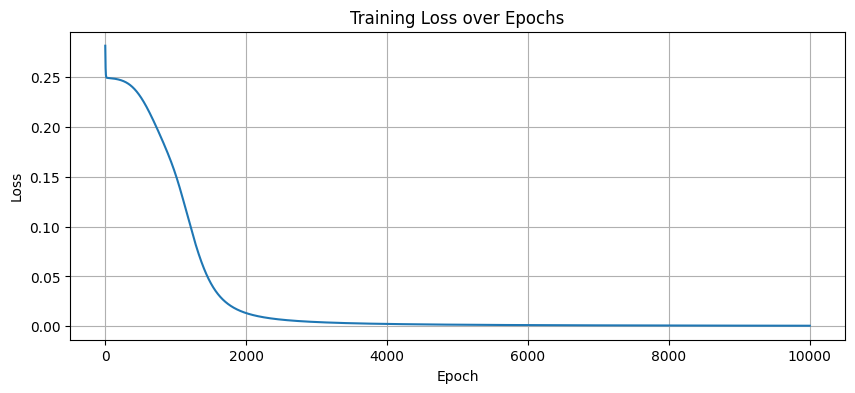

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

In [10]:
# Final predictions
_, _, _, predictions = forward(X, W1, b1, W2, b2)

print("XOR Problem Results:")
print("=" * 40)
print(f"{'Input':<15} {'Target':<10} {'Predicted':<10} {'Rounded':<10}")
print("-" * 40)
for i in range(len(X)):
    input_val = X[i].tolist()
    target = y[i].item()
    pred = predictions[i].item()
    rounded = round(pred)
    print(f"{str(input_val):<15} {target:<10.0f} {pred:<10.4f} {rounded:<10.0f}")

print("\n✓ The MLP has learned the XOR function!")

XOR Problem Results:
Input           Target     Predicted  Rounded   
----------------------------------------
[0.0, 0.0]      0          0.0131     0         
[0.0, 1.0]      1          0.9736     1         
[1.0, 0.0]      1          0.9778     1         
[1.0, 1.0]      0          0.0312     0         

✓ The MLP has learned the XOR function!


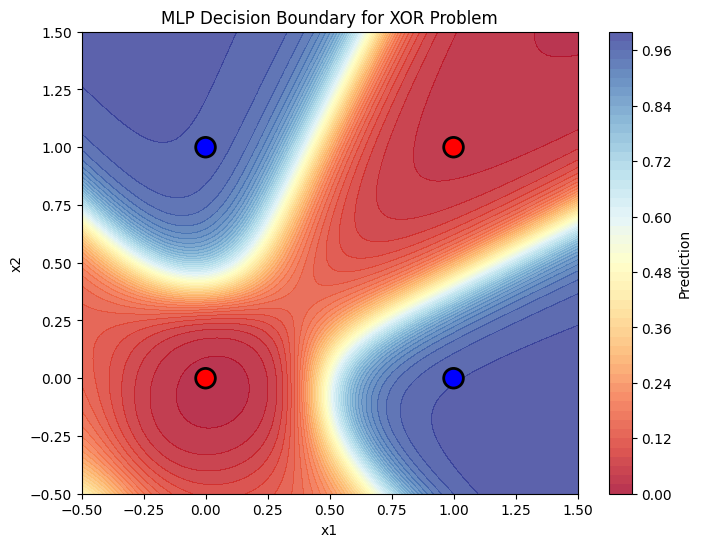

In [11]:
# Create a mesh grid for visualization
x_min, x_max = -0.5, 1.5
y_min, y_max = -0.5, 1.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Get predictions for the grid
grid_input = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
_, _, _, grid_pred = forward(grid_input, W1, b1, W2, b2)
grid_pred = grid_pred.numpy().reshape(xx.shape)

# Plot
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, grid_pred, levels=50, cmap='RdYlBu', alpha=0.8)
plt.colorbar(label='Prediction')

# Plot data points
colors = ['red' if label == 0 else 'blue' for label in y.numpy().flatten()]
plt.scatter(X[:, 0].numpy(), X[:, 1].numpy(), c=colors, s=200, edgecolors='black', linewidth=2)

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('MLP Decision Boundary for XOR Problem')
plt.show()